In [1]:
%matplotlib notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from keras.preprocessing.image import ImageDataGenerator 


Using TensorFlow backend.


In [2]:
import json
def load_and_format(in_path):
    out_df = pd.read_json(in_path)  
    out_images = out_df.apply(lambda c_row: [np.stack([c_row['band_1'],c_row['band_2'],np.add(c_row['band_1'],c_row['band_2'])/2], -1).reshape((75,75,3))],1)
    out_images = np.stack(out_images).squeeze()
    return out_df, out_images
train_df, train_images = load_and_format('data/train.json')
print('training', train_df.shape, 'loaded', train_images.shape)

training (1604, 5) loaded (1604, 75, 75, 3)


In [102]:
def plot_list(arr):
    fig = plt.figure()
    gs1 = gridspec.GridSpec(len(arr),1)
    for idx,ar in zip(range(len(arr)),arr):        
        ax = fig.add_subplot(gs1[idx])
        ax.plot(ar)
        
    gs1.tight_layout(fig)
    
import tensorflow as tf
def create_placeholders():
     ###place holders 
    global input_,input_post,label,keep_prob
    input_ = tf.placeholder(tf.float32, (None, 75, 75,3), name = 'features')
    input_post = tf.placeholder(tf.float32, (None,1), name = 'features2')
    label = tf.placeholder(tf.int32, (None, 2), name = 'labels')
    keep_prob = tf.placeholder(tf.float32)

tf.reset_default_graph()

In [103]:
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
state=2222
X_train, X_test, y_train, y_test,train_index,test_index = train_test_split(train_images,
                                                   to_categorical(train_df['is_iceberg']),range(len(train_images)),
                                                    random_state = state,
                                                    test_size = 0.2
                                                   )
X_train_ang,X_test_ang  = train_test_split(train_df['inc_angle'].replace('na',0) / 50,random_state = state,test_size = 0.2)
print('Train', X_train.shape, y_train.shape)
print('Validation', X_test.shape, y_test.shape)

Train (1283, 75, 75, 3) (1283, 2)
Validation (321, 75, 75, 3) (321, 2)


In [112]:
def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.1), name="weight")
def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]), name ="bias")
def new_conv_layer(input,              # The previous layer.
                   num_input_channels, # Num. channels in prev. layer.
                   filter_size,        # Width and height of each filter.
                   num_filters,        # Number of filters.
                   use_pooling=True):  # Use 2x2 max-pooling.

    
    shape = [filter_size, filter_size, num_input_channels, num_filters]

    # Create new weights aka. filters with the given shape.
    weights = new_weights(shape)

    # Create new biases, one for each filter.
    biases = new_biases(num_filters)
    
    # Note the strides are set to 1 in all dimensions.
    # The first and last stride must always be 1,
    # because the first is for the image-number and
    # the last is for the input-channel.
    # But e.g. strides=[1, 2, 2, 1] would mean that the filter
    # is moved 2 pixels across the x- and y-axis of the image.
    # The padding is set to 'SAME' which means the input image
    # is padded with zeroes so the size of the output is the same.
    layer = tf.nn.conv2d(input=input,
                         filter=weights,
                         strides=[1, 1, 1, 1],
                         padding='SAME')

    layer += biases

    # Use pooling to down-sample the image resolution?
    if use_pooling:
        # This is 2x2 max-pooling, which means that we
        # consider 2x2 windows and select the largest value
        # in each window. Then we move 2 pixels to the next window.
        layer = tf.nn.max_pool(value=layer,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME')

    layer = tf.nn.relu(layer)

    return layer

In [121]:
num_channels = 3
# Convolutional Layer 1.
filter_size1 = 3          # Convolution filters are 5 x 5 pixels.
num_filters1 = 16         # There are 16 of these filters.

# Convolutional Layer 2.
filter_size2 = 3          # Convolution filters are 5 x 5 pixels.   222
num_filters2 = 36         # There are 36 of these filters.

# Convolutional Layer 3
filter_size3 = 3          # Convolution filters are 5 x 5 pixels.
num_filters3 = 64         # There are 36 of these filters.

# Convolutional Layer 4
filter_size4 = 3          # Convolution filters are 5 x 5 pixels.
num_filters4 = 64         # There are 36 of these filters.

# Convolutional Layer 5
filter_size5 = 3          # Convolution filters are 5 x 5 pixels.
num_filters5 = 32         # There are 36 of these filters.

# Fully-connected layer.
fc_size = 128           # Number of neurons in fully-connected layer.

In [124]:
def CNN(x):
   
    ####33##########
    #batch_norm = tf.layers.batch_normalization(x, training=is_train)
    
    layer_conv1 = new_conv_layer(input=x,
                       num_input_channels=num_channels,
                       filter_size=filter_size1,
                       num_filters=num_filters1,
                       use_pooling=False)
    layer_conv1 = new_conv_layer(input=layer_conv1,
                       num_input_channels=num_filters1,
                       filter_size=filter_size1,
                       num_filters=num_filters1,
                       use_pooling=True)
    drop_conv1 = tf.nn.dropout(layer_conv1, 0.75 + keep_prob*0.25)
    
    layer_conv2 = new_conv_layer(input=drop_conv1,
                       num_input_channels=num_filters1,
                       filter_size=filter_size2,
                       num_filters=num_filters2,
                       use_pooling=False)
    layer_conv2 = new_conv_layer(input=layer_conv2,
                       num_input_channels=num_filters2,
                       filter_size=filter_size2,
                       num_filters=num_filters2,
                       use_pooling=True)
    drop_conv2 = tf.nn.dropout(layer_conv2, 0.85 + keep_prob*0.15)
    
    layer_conv3 = new_conv_layer(input=drop_conv2,
                       num_input_channels=num_filters2,
                       filter_size=filter_size3,
                       num_filters=num_filters3,
                       use_pooling=True)
    drop_conv3 = tf.nn.dropout(layer_conv3, 0.90 + keep_prob*0.10)
    print(drop_conv3.shape)
    
    layer_conv4 = new_conv_layer(input=drop_conv3,
                       num_input_channels=num_filters3,
                       filter_size=filter_size4,
                       num_filters=num_filters4,
                       use_pooling=True)
    layer_conv4 = new_conv_layer(input=layer_conv4,
                       num_input_channels=num_filters4,
                       filter_size=filter_size4,
                       num_filters=num_filters4,
                       use_pooling=True)
    
    

    # Shortcut
    #flatten_layer = tf.contrib.layers.flatten(max_pool2)
    #fc = tf.contrib.layers.full_connected(flatten_layer, 256)
    
    # Long way of doing the fully_connected_layer
    _, height, width, depth = layer_conv4.shape
    print(layer_conv4.shape)
    tensor_size = int(height * width * depth +1) 
    flatten_layer = tf.reshape(layer_conv4, [-1, tensor_size-1])
    
    fc1_hidden_unit = int(tensor_size/8)
    print(fc1_hidden_unit)
    drop_fc1 = tf.nn.dropout(flatten_layer, 0.58 + keep_prob*0.42)
    drop_feat = tf.concat( [drop_fc1, input_post ], 1 )
    W_fc1 = new_weights([tensor_size, fc1_hidden_unit])
    b_fc1 = new_biases(fc1_hidden_unit)
    
    fc1 = tf.nn.relu(tf.add(tf.matmul(drop_feat, W_fc1), b_fc1))
    drop_fc2 = tf.nn.dropout(fc1, 0.85 + 0.15*keep_prob)   #85
    
    n_class = 2
    W_fc2 = new_weights([fc1_hidden_unit, n_class])
    b_fc2 = new_biases(n_class)
                     
    logits = tf.add(tf.matmul(drop_fc2, W_fc2), b_fc2)
    
    return logits

In [125]:
tf.reset_default_graph()
create_placeholders()
logits = CNN(input_)
logits_soft =tf.nn.softmax(logits)

cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels = label, logits = logits)
step = tf.Variable(0,trainable=False)
#error = tf.square(label-logits)/2
var_s = tf.trainable_variables()
loss_l2 = tf.add_n([tf.nn.l2_loss(v) for v in var_s if 'bias' not in v.name])*0.001
loss = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer().minimize(loss)
accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(logits, 1), tf.argmax(label, 1)), tf.float32))

(?, 10, 10, 64)
(?, 3, 3, 64)
72


In [126]:
epoch = 15
batch_size =32

sess = tf.Session()
sess.run(tf.global_variables_initializer())

saver = tf.train.Saver()
best_accuracy,min_loss = 0,10
acc_rec, loss_rec, loss_train = [], [], []

from keras.preprocessing.image import ImageDataGenerator 
datagen = ImageDataGenerator(
                            width_shift_range=0.3,
                            height_shift_range=0.3,
                            zoom_range=0.1,
                            rotation_range = 5,
                            horizontal_flip=True,
                            vertical_flip=True,
                            fill_mode='nearest')
datagen.fit(X_train)

len_train = len(y_train)
def create_batches(n_batch, batch_size = batch_size, len_ = len_train):
    idx1 = n_batch*batch_size
    idx2 = n_batch*batch_size + batch_size
    arr = list(range(len_))
    if idx2>len_:
        idx2 = len_
        return arr[idx1:idx2],False
    return arr[idx1:idx2],True

y_datagen = [[y_train[x,0],y_train[x,1],X_train_ang.values[x]] for x in range(len(y_train))]

In [127]:
len_train = len(y_train)
def create_batches(n_batch, batch_size = batch_size, len_ = len_train):
    idx1 = n_batch*batch_size
    idx2 = n_batch*batch_size + batch_size
    if idx2>len_:
        idx2 = len_
        return range(len_)[idx1:idx2],False
    return range(len_)[idx1:idx2],True

y_datagen = [[y_train[x,0],y_train[x,1],X_train_ang.values[x]] for x in range(len(y_train))]

In [142]:
for e in range(80):
    n_batch = 0
    status =True
    for x_batch, y_batch in datagen.flow(X_train, y_datagen, batch_size=batch_size):
        _, loss_ = sess.run([optimizer, loss], feed_dict = {input_: x_batch,
                                                         label: y_batch[:,:2],
                                                         input_post:y_batch[:,2:],
                                                         keep_prob:0
                                                         } )
        
        
        if n_batch % 40 == 0:
            val_feed_dict = {input_: X_test,
                             label: y_test,
                             input_post:X_test_ang.values.reshape([-1,1]),
                             keep_prob:1
                             }
            val_loss = sess.run(loss, feed_dict = val_feed_dict)
            val_acc = accuracy.eval(feed_dict = val_feed_dict,session=sess)
            acc_rec.append(val_acc)
            loss_rec.append(val_loss)
            loss_train.append(loss_)
            if val_acc > best_accuracy:
                best_accuracy = val_acc
                saver.save(sess, 'models/my_model_acc')
                imp_str_acc = '*'*4
            else:
                imp_str_acc = ''
            if val_loss<min_loss:
                min_loss = val_loss
                saver.save(sess, 'models/my_model_loss')
                imp_str_loss = '*'*4
            else:
                imp_str_loss = ''
                        
            msg = "Epoch {}   Batch #{}: Valditaion Loss: {:.3}{}, Validation Accuracy: {:.3}{}"
            print(msg.format(e, n_batch, val_loss,imp_str_loss, val_acc, imp_str_acc))
        n_batch +=1
        if n_batch*batch_size>len_train:
            break


Epoch 0   Batch #0: Valditaion Loss: 0.223, Validation Accuracy: 0.894
Epoch 0   Batch #40: Valditaion Loss: 0.222, Validation Accuracy: 0.897
Epoch 1   Batch #0: Valditaion Loss: 0.22, Validation Accuracy: 0.894
Epoch 1   Batch #40: Valditaion Loss: 0.184, Validation Accuracy: 0.935
Epoch 2   Batch #0: Valditaion Loss: 0.186, Validation Accuracy: 0.925
Epoch 2   Batch #40: Valditaion Loss: 0.187, Validation Accuracy: 0.925
Epoch 3   Batch #0: Valditaion Loss: 0.186, Validation Accuracy: 0.925
Epoch 3   Batch #40: Valditaion Loss: 0.249, Validation Accuracy: 0.882
Epoch 4   Batch #0: Valditaion Loss: 0.252, Validation Accuracy: 0.879
Epoch 4   Batch #40: Valditaion Loss: 0.179, Validation Accuracy: 0.928
Epoch 5   Batch #0: Valditaion Loss: 0.18, Validation Accuracy: 0.928
Epoch 5   Batch #40: Valditaion Loss: 0.221, Validation Accuracy: 0.894
Epoch 6   Batch #0: Valditaion Loss: 0.213, Validation Accuracy: 0.897
Epoch 6   Batch #40: Valditaion Loss: 0.321, Validation Accuracy: 0.847
E

Epoch 57   Batch #0: Valditaion Loss: 0.194, Validation Accuracy: 0.907
Epoch 57   Batch #40: Valditaion Loss: 0.261, Validation Accuracy: 0.897
Epoch 58   Batch #0: Valditaion Loss: 0.285, Validation Accuracy: 0.891
Epoch 58   Batch #40: Valditaion Loss: 0.206, Validation Accuracy: 0.91
Epoch 59   Batch #0: Valditaion Loss: 0.204, Validation Accuracy: 0.91
Epoch 59   Batch #40: Valditaion Loss: 0.209, Validation Accuracy: 0.91
Epoch 60   Batch #0: Valditaion Loss: 0.211, Validation Accuracy: 0.907
Epoch 60   Batch #40: Valditaion Loss: 0.227, Validation Accuracy: 0.9
Epoch 61   Batch #0: Valditaion Loss: 0.225, Validation Accuracy: 0.9
Epoch 61   Batch #40: Valditaion Loss: 0.213, Validation Accuracy: 0.907
Epoch 62   Batch #0: Valditaion Loss: 0.206, Validation Accuracy: 0.913
Epoch 62   Batch #40: Valditaion Loss: 0.211, Validation Accuracy: 0.919
Epoch 63   Batch #0: Valditaion Loss: 0.222, Validation Accuracy: 0.913
Epoch 63   Batch #40: Valditaion Loss: 0.188, Validation Accuracy

<IPython.core.display.Javascript object>


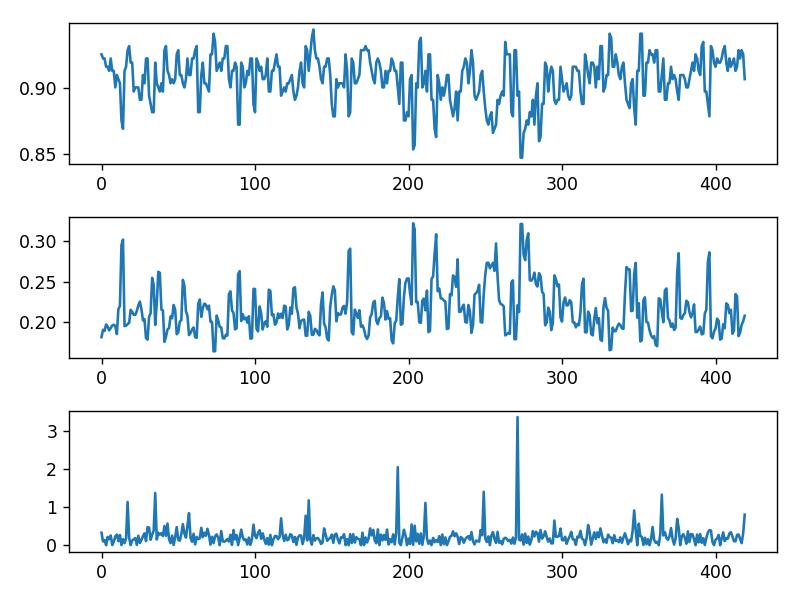

best Acc: 0.944, Min loss: 0.155


In [143]:
%matplotlib notebook

plot_list([acc_rec[700:],loss_rec[700:],loss_train[700:]])
print('best Acc: {:.3}, Min loss: {:.3}'.format(best_accuracy,min_loss))

In [149]:
acc_rec = np.array(acc_rec)
acc_rec[loss_rec[:]==min(loss_rec)]

array([ 0.94080985], dtype=float32)

In [61]:
np.floor(1.8)

1.0

In [148]:
def predict_batch(test_imgages,inc_ang,length = 1000):
    prev_index = 0
    for x in range(int(np.floor(len(inc_ang)/length))):
        index = (x+1) * length
        feed_dict_sub = {input_: test_imgages[prev_index:index], input_post:inc_ang[prev_index:index], keep_prob:1} 
        
        
        pred = sess.run(logits_soft,feed_dict=feed_dict_sub)
        if x == 0:
            return_sub = pred
        else:
            return_sub = np.concatenate((return_sub,pred))
        prev_index = index
    feed_dict_sub = {input_: test_imgages[prev_index:], input_post:inc_ang[prev_index:], keep_prob:1} 
    pred = sess.run(logits_soft,feed_dict=feed_dict_sub)
    return_sub = np.concatenate((return_sub,pred))
    return return_sub

In [63]:
test_df, test_imgages = load_and_format('data/test.json')
print('ok')

ok


In [150]:
inc_ang = test_df['inc_angle'].replace('na',0) / 50
inc_ang = inc_ang.as_matrix().reshape([-1,1])

In [151]:
saver.restore(sess,"models/my_model_loss")
sub_loss = predict_batch(test_imgages,inc_ang)
saver.restore(sess,"models/my_model_acc")
sub_acc = predict_batch(test_imgages,inc_ang)


INFO:tensorflow:Restoring parameters from models/my_model_loss
INFO:tensorflow:Restoring parameters from models/my_model_acc


In [152]:
sub_loss = [1-p[0] if np.argmax(p)==0 else p[1]  for p in sub_loss]
sub_acc = [1-p[0] if np.argmax(p)==0 else p[1]  for p in sub_acc]
sub_data = (np.array(sub_loss) + np.array(sub_acc))/2

In [154]:
sub = pd.DataFrame()
sub['id'] = test_df['id']
sub['is_iceberg'] = sub_loss

In [155]:
sub.to_csv("sub/sub_loss{:.3}_acc{:.3}.csv".format(min_loss,best_accuracy), index = False)